In [ ]:
from landlab.grid.mappers import map_link_vector_components_to_node

# imports
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.components import TidalFlowCalculator
from landlab.grid.mappers import map_max_of_link_nodes_to_link
from landlab.io import read_esri_ascii
import tidal_erosion_calculator as tec

In [ ]:
# Set parameters (these are from the MarshMorpho2D source code)
tidal_period = 12.5 * 3600.0  # tidal period in seconds
tidal_range = 3.1  # tidal range in meters
roughness_w = 0.02  # Manning's n water
roughness_v = 0.2 #manning's n for veg
mean_sea_level = 0.0  # mean sea level in meters
mwd = 0.01  # minimum depth for water on areas higher than low tide water surface, meters
nodata_code = 999  # code for a DEM cell with no valid data

# Read the DEM to create a grid and topography field
(grid, z) = read_esri_ascii('zSW3.asc', name='topographic__elevation')

#need to create vegetation grid #change to veg at cells
veg = grid.add_zeros('vegetation',at='node');
veg[z<0] = 1;
veg_atlink = grid.map_max_of_link_nodes_to_link('vegetation')
grid.add_field('veg_atlink',veg_atlink,at='link')

# Configure boundaries: any nodata nodes, plus any nodes higher than mean high tide
grid.status_at_node[z==nodata_code] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[z>1.8] = grid.BC_NODE_IS_CLOSED
boundaries_above_msl = np.logical_and(grid.status_at_node==grid.BC_NODE_IS_FIXED_VALUE, z > 0.0)
grid.status_at_node[boundaries_above_msl] = grid.BC_NODE_IS_CLOSED

print('pre tfc:')
print(grid.at_node.keys())
print(grid.at_link.keys())

#variable rougness as field in grid
roughness_at_nodes = roughness_w + np.zeros(z.size)
roughness_at_nodes[z < 0.0] = roughness_v #or roughness_at_nodes[veg] = roughness_v
roughness = grid.add_zeros('roughness', at='link')
map_max_of_link_nodes_to_link(grid, roughness_at_nodes, out=roughness)

# Instantiate a TidalFlowCalculator component
tfc = TidalFlowCalculator(
        grid,
        tidal_period=tidal_period,
        tidal_range=tidal_range,
        roughness='roughness',
        mean_sea_level=mean_sea_level,
        min_water_depth=mwd,
)

In [ ]:
tau_cr = 0.2 #Critical stress for unvegetated areas
tau_crv = 0.5  #Critical stress for vegetated areas
mud_erodability = (10**-5)*24*3600;  # mud erodability kg/m2/day!!!

v = grid.at_link['veg_atlink']
tec.populateGrids(grid,tfc,tau_cr,tau_crv,v)
print(grid.at_cell.keys())
print(grid.at_node.keys())

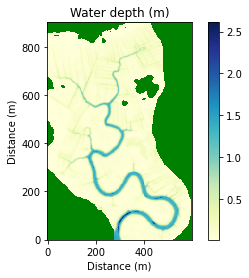

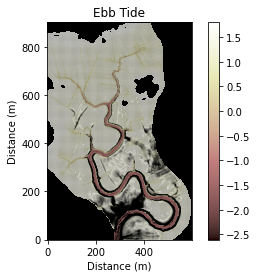

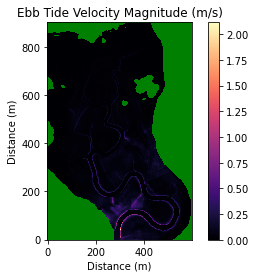

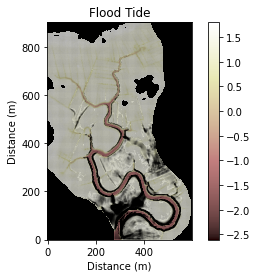

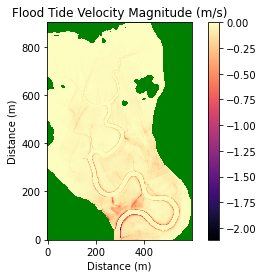

In [4]:
tec.plot_tidal_flow(grid)

In [5]:
ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability)
#ok so for some reason erosion value is SUPER high -- no clue why...need to clear that up!

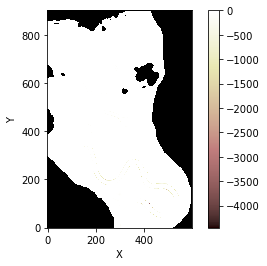

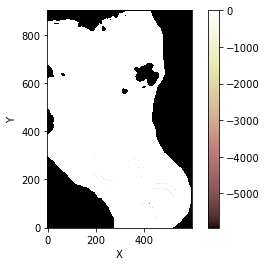

In [8]:
for i in range(2):
    ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability)
    z = grid.at_node['topographic__elevation']
    z -= ero
    tfc.run_one_step()
    plt.figure()
    imshow_grid(grid,grid.at_node['topographic__elevation'])
    